In [1]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth' # get the Segment anything model checkpoints

**Installation of SAM and Supervision library (for better view of output)**

In [2]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-q12uef1c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-q12uef1c
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=f23f15536e8c3a738f201864df2537aed868c23e8623165193b609b7722f7a93
  Stored in directory: /tmp/pip-ephem-wheel-cache-9vpnlfhn/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 614.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

**Download and Install Yolov5 ultralytics library**

In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-225-gbb9706e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


**Hand detection and segmentation**
As we have train our Yolov5 network already and we have final weights. Based on those weights we will fo the **hand detection** first and we will extract the Bounding Box of hand and will pass that Bounding Box to Segment anything model to extract the segmentation mask of that object. Finaly we will show the mask without backhground.

In [4]:
import torch
from segment_anything import sam_model_registry
checkpoint = "/content/sam_vit_h_4b8939.pth" ## provide downloaded checkpoint path
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=checkpoint)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20913549 parameters, 0 gradients, 48.1 GFLOPs
Adding AutoShape... 


0


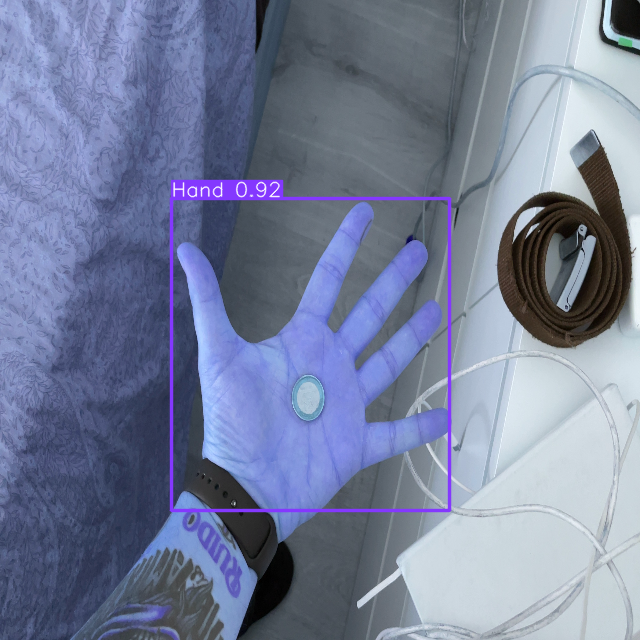

In [43]:
import cv2
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from PIL import Image
import numpy as np
import os
import torch

mask_generator = SamAutomaticMaskGenerator(sam)
mask_predictor = SamPredictor(sam)

BBox = [42, 1032, 2112, 2878] ## random given if yolov5 didnot detect box so this will use for segmentation
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/hand_best.pt')  ## load custom model and weights

for i,filename in enumerate(os.listdir("/content/drive/MyDrive/hand_dataset1/hand_dataset1/")):
  head,ext = os.path.splitext(filename)
  image_bgr = cv2.imread("/content/drive/MyDrive/hand_dataset1/hand_dataset1/hand11.jpeg")#+filename)
  image_bgr = cv2.resize(image_bgr, [640,640]) ## resize image as we used in yolov5 training
  results = model(image_bgr)

  BB = results.xyxy[0]
  if (BB.nelement()!= 0):
    BBox = [int(BB[0,0]),int(BB[0,1]),int(BB[0,2]),int(BB[0,3])]

  # print(BBox )
  # image_bgr = cv2.imread("/content/drive/MyDrive/hand_dataset1/hand_dataset1/"+filename)

  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  mask_predictor.set_image(image_rgb)

  box = np.array(BBox)
  masks, scores, logits = mask_predictor.predict(
      box=box,
      multimask_output=True
  )

  img = Image.fromarray(masks[0])
  img.save('/content/Hands_output/'+filename)
  print(i)
  break
results.show()

In [34]:
BB.nelement()

0

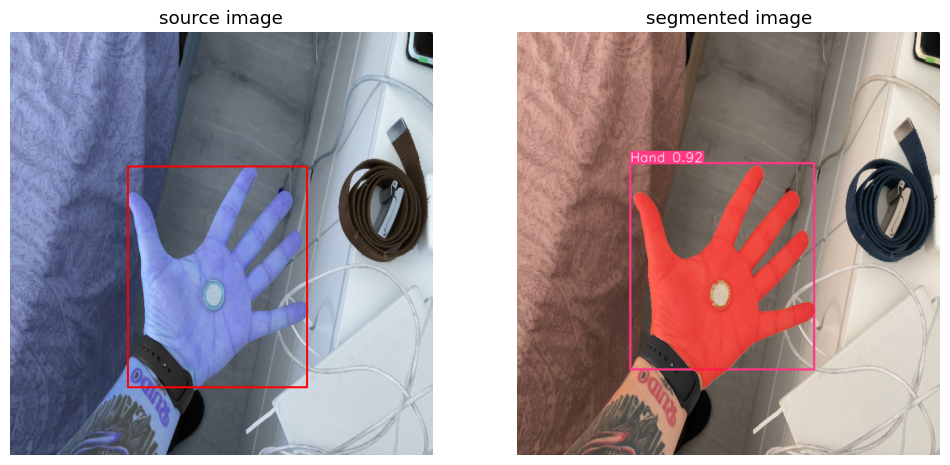

In [58]:
import supervision as sv
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]
# img = Image.fromarray(masks[0])
source_image = box_annotator.annotate(scene=image_rgb.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1,2),
    titles=['source image', 'segmented image']
)

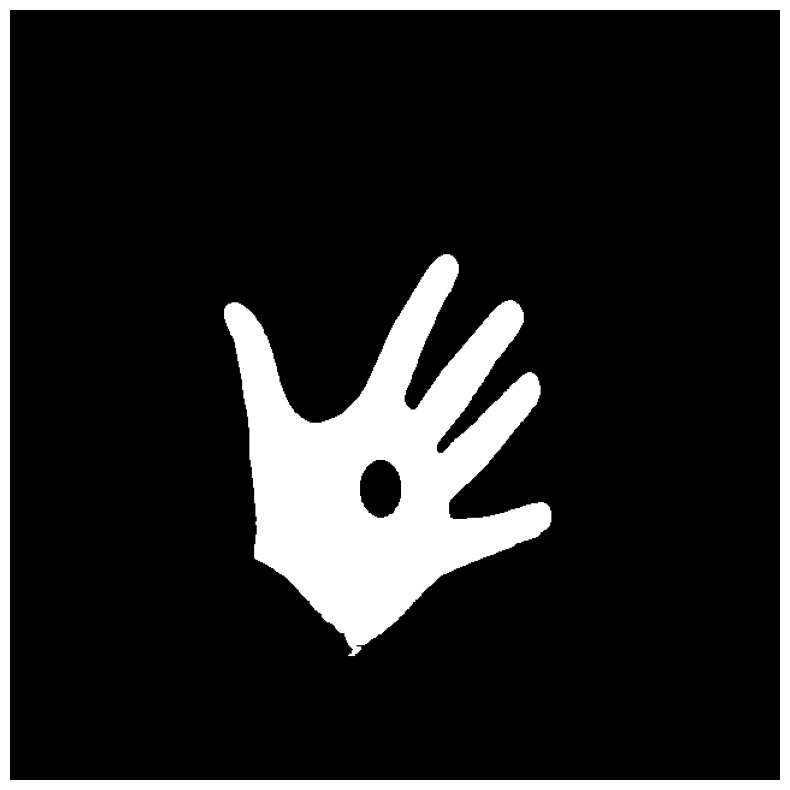

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()